21.582000000000004


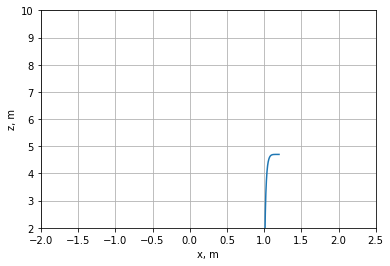

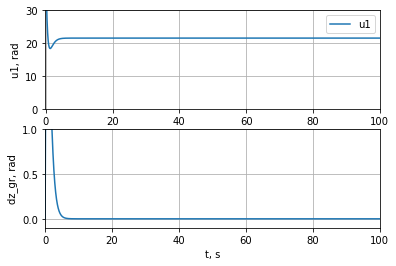

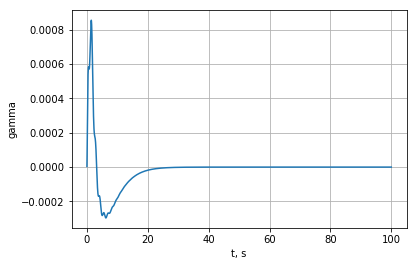

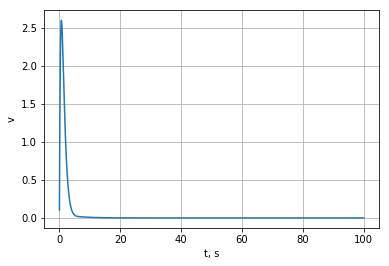

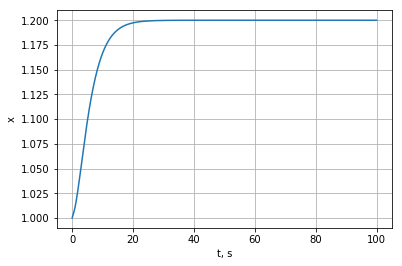

In [14]:
from math import *
from random import random, gauss

M1 = 2.2    # kg
M2 = 0.
G = 9.81     # m/c^2
L = 0.7 # m
#MG = M * G
Ixx = 0.167
Iyy = 0.167 # + (M1+M2)*(3./13.)*(3./13.)*L*L
Izz = 1.

class Model:

    def __init__(self, x=0., z=0., theta=0., gamma = 0.):
        # init state
        self.x = x
        self.z = z
        self.theta = theta
        self.gamma = gamma

        # init speed
        self.dx = 0.
        self.dz = 0.
        self.dtheta = 0.
        self.dgamma = 0.

        
    def step(self, u3, u1, dt):

      #  u1 = G*(M1+M2)
        d2theta = u3/Iyy
        self.dtheta += d2theta*dt
        self.theta += self.dtheta*dt
        
        mu1 = 0.
        
#       d2gamma = (M2+M1)/M1*((-*G/L)*(sin(self.gamma) - 1)-u1*(sin(self.theta) + cos(self.theta))/((M1+M2)*L))
        d2gamma = (-u1*sin(self.theta + self.gamma) + mu1*self.dx*abs(self.dx)*cos(self.gamma))/(M1*L)
        #d2gamma = 0.
        self.dgamma += d2gamma*dt
        self.gamma += self.dgamma*dt
        
        d2x = (u1*sin(self.theta)+M2*L*(sin(self.gamma)*self.dgamma*self.dgamma - cos(self.gamma)*d2gamma)- mu1*self.dx*abs(self.dx))/(M1+M2)
        self.dx += d2x*dt
        self.x += self.dx * dt
        
        d2z = (u1*cos(self.theta) - (M1+M2)*G + M2*L*(-cos(self.gamma)*self.dgamma*self.dgamma - sin(self.gamma)*d2gamma))/(M1+M2)
        self.dz += d2z * dt
        self.z += self.dz * dt 
       


if __name__ == '__main__':
    import matplotlib
 #   matplotlib.use('GTK')
    import pylab
    
    log_model = open('smart_reg_model','w')
    x =[]; z = []; theta = []; gamma = []; t = []; x_gr1 = [];dz_gr1 = [];
    x1 = 0
    z1 = 0
    v =[]
    DT = 0.01
    TIME = 100.
    
    model = Model(x=1., z=0.)
    model.dx = 0.01
    model.dy = 0.01
    model.dz = 0.0
    
    theta_ref = -0.05
#    k1 = 1.
#    k2 = 1.
#    k3 = 1.
#    k4 = 1.
    
    z_ref = 4.
    x_ref = 1.2
    


    k_z = 1.5
    alpha = k_z


    const = 8.
    k_t = const
    alpha2 = 1.
    k_gamma = alpha2

    
    betta = 0.3
    k_x = betta
    
    u1 = (M1+M2)*G  
    print (u1)
    u11 = []
    u33 = []
    u3 = 0
    
    for i in range(int(TIME / DT)):
        z_speed_cmd = 0.
        
        #if ((i*DT) % 20 == 0):
           # dx_ref = -1.*dx_ref
            #theta_ref = -1*theta_ref
        z_gr = model.z - L*cos(model.gamma)
        dz_gr = model.dz +  model.dgamma*L*sin(model.gamma)
        x_gr = model.x + L*sin(model.gamma)
        dx_gr = model.dx + model.dgamma*L*cos(model.gamma)
        Ax = -M1*L*model.dgamma*model.dgamma*sin(model.gamma)/(M1+M2) + dx_gr*(k_x + betta) + k_x*betta*(x_gr - x_ref)
        #Ax = 0
        deltaz = z_gr - z_ref
        #if (deltaz >= 0.5):
        #      deltaz = 0.5
        #     dz_gr = 0.1
        Az = M1*L*model.dgamma*model.dgamma*cos(model.gamma)/(M1+M2)+dz_gr*(k_z+alpha)+k_z*alpha*deltaz - G
        
       
            
       # u1 = sqrt(M1*M1*L*L*alpha2*alpha2*model.dgamma*model.dgamma + (M1+M2)*(M1+M2)*(Ax*Ax+Az*Az))
#        Axx = Ax - M1*L*alpha2*model.dgamma*cos(model.gamma)/(M1+M2)
#        Azz = Az - M1*L*alpha2*model.dgamma*sin(model.gamma)/(M1+M2)

        Axx = Ax - 1.*cos(model.gamma)*M1*((alpha2+k_gamma)*model.dgamma+alpha2*k_gamma*model.gamma)/(M1+M2)
        Azz = Az - 1.*sin(model.gamma)*M1*((alpha2+k_gamma)*model.dgamma+alpha2*k_gamma*model.gamma)/(M1+M2)
 
        u1 = (M1+M2)*sqrt(Axx*Axx + Azz*Azz)
        theta_ref = atan(Axx/Azz)
        
       # St = model.dtheta + k_t*(model.theta - theta_ref)
        u3 = Iyy*(-(const+k_t)*model.dtheta - k_t*const*(model.theta - theta_ref))
        
        model.step(u3, u1, DT)
        
        x_gr1.append(model.x + L*sin(model.gamma))
        dz_gr1.append(dz_gr)
        x.append(model.x)
        z.append(model.z)
        
        theta.append(model.theta)
        gamma.append(model.gamma)
        u11.append(u1)
        u33.append(u3)
       
        
        t.append(i * DT)
        
        v.append(sqrt(model.dx*model.dx + model.dz * model.dz))
        
        log_model.write("%f %f %f %f %f %f %f\n" % (i*DT,dx_gr,z_gr,model.theta,model.gamma, u3, v[i])) #t,x,y,theta
        log_model.flush()
        
    pylab.figure()
    line, = pylab.plot(x, z)
    pylab.grid(True)
    pylab.axis([-2.,2.5,2.,10])
    pylab.xlabel('x, m')
    pylab.ylabel('z, m')
    
    pylab.figure()
    pylab.subplot(211)
    line, =pylab.plot(t, u11)
    line.set_label('u1')
    pylab.grid(True)
    pylab.legend(loc = 'best')
    pylab.axis([-0.2,TIME,0,30]) 
    pylab.xlabel('t, s')
    pylab.ylabel('u1, rad')
    
    pylab.subplot(212)
    pylab.plot(t, dz_gr1)
    pylab.grid(True)
    pylab.axis([0,TIME,-0.1,1.])
    pylab.xlabel('t, s')
    pylab.ylabel('dz_gr, rad')
    
    pylab.figure()
    pylab.plot(t, theta)
    pylab.grid(True)
    pylab.xlabel('t, s')
    pylab.ylabel('theta')


    pylab.figure()
    pylab.plot(t, v)
    pylab.grid(True)
    pylab.xlabel('t, s')
    pylab.ylabel('v')
    
    pylab.figure()
    pylab.plot(t, x_gr1)
    pylab.grid(True)
    pylab.xlabel('t, s')
    pylab.ylabel('x')
    
    pylab.show()
    log_model.close()